In [1]:
!pip uninstall opencv-python -y
!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

Skipping opencv-python as it is not installed.
  Using cached https://files.pythonhosted.org/packages/12/32/8d32d40cd35e61c80cb112ef5e8dbdcfbb06124f36a765df98517a12e753/opencv_contrib_python-3.4.2.17-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/1f/df/7988fbbdc8c9b8efb575029498ad84b77e023a3e4623e85068823a102b1d/numpy-1.18.4-cp37-cp37m-manylinux1_x86_64.whl
tables 3.5.1 requires mock>=2.0, which is not installed.
  Found existing installation: numpy 1.18.4
    Uninstalling numpy-1.18.4:
      Successfully uninstalled numpy-1.18.4
  Found existing installation: opencv-contrib-python 3.4.2.17
    Uninstalling opencv-contrib-python-3.4.2.17:
      Successfully uninstalled opencv-contrib-python-3.4.2.17


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import morphology as morp
import glob
import os 

In [3]:
img1=cv2.imread('box.png', cv2.IMREAD_GRAYSCALE)
img2=cv2.imread('box_in_scene.png', cv2.IMREAD_GRAYSCALE)
vect =[]
for i in range(-1, 2):
    for j in range(-1, 2):
        vect.append(img1[15+i, 15+j])
vect = np.asarray(vect)
vect

array([196, 195, 198, 196, 196, 199, 197, 196, 198], dtype=uint8)

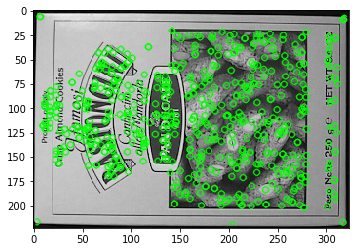

In [4]:
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
plt.imshow(cv2.drawKeypoints(img1,kp1,None,color=(0,255,0)))

Text(0.5, 0, '(b)')

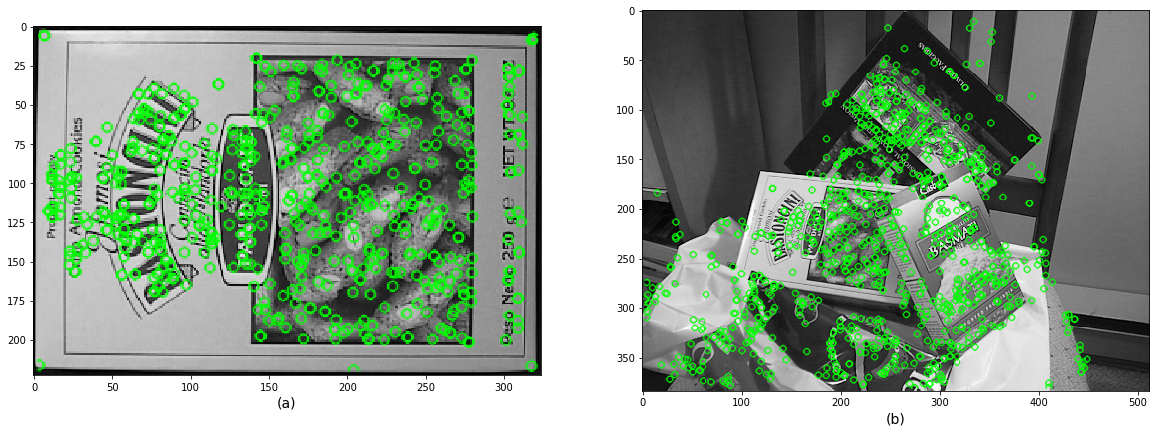

In [5]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(img1,kp1,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(img2,kp2,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

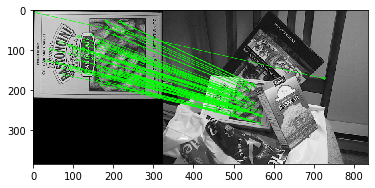

In [6]:
match = cv2.BFMatcher()
matches = match.knnMatch(des1,des2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

draw_params = dict(matchColor=(0,255,0),
                       singlePointColor=None,
                       flags=2)

img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.imshow(img3)

Text(0.5, 0, '(b)')

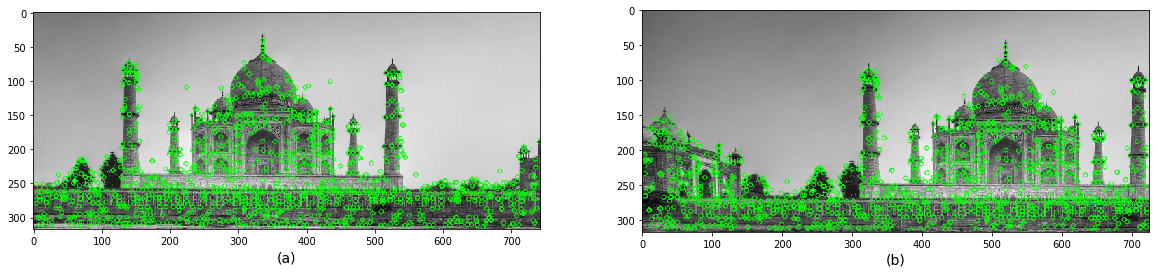

In [7]:
img4 = cv2.imread('img2_2.png', cv2.IMREAD_UNCHANGED)
img5 = cv2.imread('img2_1.png', cv2.IMREAD_UNCHANGED)
image1_gray=cv2.cvtColor(img4,cv2.COLOR_BGR2GRAY)
image2_gray=cv2.cvtColor(img5,cv2.COLOR_BGR2GRAY)

image1=cv2.cvtColor(img4,cv2.COLOR_BGR2RGB)
image2=cv2.cvtColor(img5,cv2.COLOR_BGR2RGB)
sift =cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(image1_gray,None)
kp2, des2 = sift.detectAndCompute(image2_gray,None)
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(image1_gray,kp1,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(image2_gray,kp2,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)


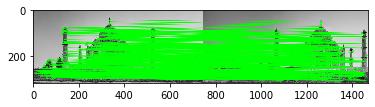

In [8]:
match = cv2.BFMatcher()
matches = match.knnMatch(des1,des2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.03*n.distance:
        good.append(m)

draw_params = dict(matchColor=(0,255,0),
                       singlePointColor=None,
                       flags=2)

img3 = cv2.drawMatches(image1_gray,kp1,image2_gray,kp2,good,None,**draw_params)
plt.imshow(img3)

In [9]:
MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    h,w = image2_gray.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M)
    #img2 = cv2.polylines(image2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

    #plt.imshow(img2)
else:
    print("Not enought matches are found - %d/%d", (len(good)/MIN_MATCH_COUNT))

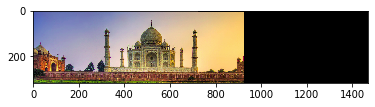

In [10]:
dst = cv2.warpPerspective(image1,M,(image2.shape[1] + image1.shape[1], image2.shape[0]))
dst[0:image2.shape[0],0:image2.shape[1]] = image2
plt.imshow(dst)


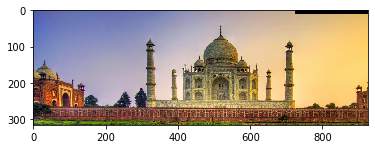

In [11]:
def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop bottom
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop left
    if not np.sum(frame[:,0]):
        return trim(frame[:,1:])
    #crop right
    if not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])
    return frame

plt.imshow(trim(dst))

# cv2.waitKey(0)
# cv2.destroyAllWindows()
#cv2.imsave("original_image_stitched_crop.jpg", trim(dst))

## Eg3

Text(0.5, 0, '(b)')

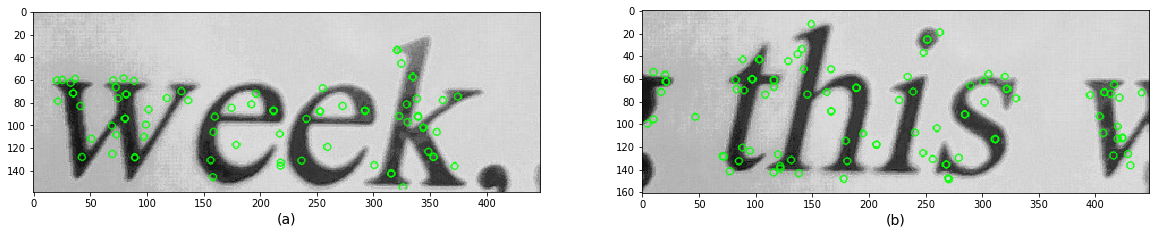

In [12]:
img6 = cv2.imread('eg3/img4_2.jpg', cv2.IMREAD_UNCHANGED)
img7 = cv2.imread('eg3/img4_1.jpg', cv2.IMREAD_UNCHANGED)
image1_gray=cv2.cvtColor(img6,cv2.COLOR_BGR2GRAY)
image2_gray=cv2.cvtColor(img7,cv2.COLOR_BGR2GRAY)

image1=cv2.cvtColor(img6,cv2.COLOR_BGR2RGB)
image2=cv2.cvtColor(img7,cv2.COLOR_BGR2RGB)
sift =cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(image1_gray,None)
kp2, des2 = sift.detectAndCompute(image2_gray,None)
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(image1_gray,kp1,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(image2_gray,kp2,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

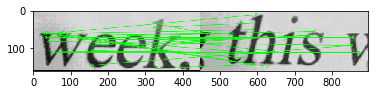

In [13]:
match = cv2.BFMatcher()
matches = match.knnMatch(des1,des2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.9*n.distance:
        good.append(m)

draw_params = dict(matchColor=(0,255,0),
                       singlePointColor=None,
                       flags=2)

img3 = cv2.drawMatches(image1_gray,kp1,image2_gray,kp2,good,None,**draw_params)
plt.imshow(img3)

In [14]:
MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    h,w = image2_gray.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M)
    #img2 = cv2.polylines(image2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

    #plt.imshow(img2)
else:
    print("Not enought matches are found - %d/%d", (len(good)/MIN_MATCH_COUNT))

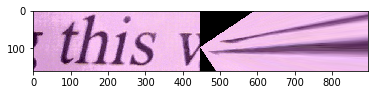

In [15]:
dst = cv2.warpPerspective(image1,M,(image2.shape[1] + image1.shape[1], image2.shape[0]))
dst[0:image2.shape[0],0:image2.shape[1]] = image2
plt.imshow(dst)


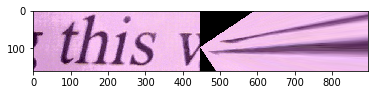

In [16]:
def trim(frame):
    #crop top
    if not np.sum(frame[0]):
        return trim(frame[1:])
    #crop bottom
    if not np.sum(frame[-1]):
        return trim(frame[:-2])
    #crop left
    if not np.sum(frame[:,0]):
        return trim(frame[:,1:])
    #crop right
    if not np.sum(frame[:,-1]):
        return trim(frame[:,:-2])
    return frame

plt.imshow(trim(dst))

Text(0.5, 0, '(b)')

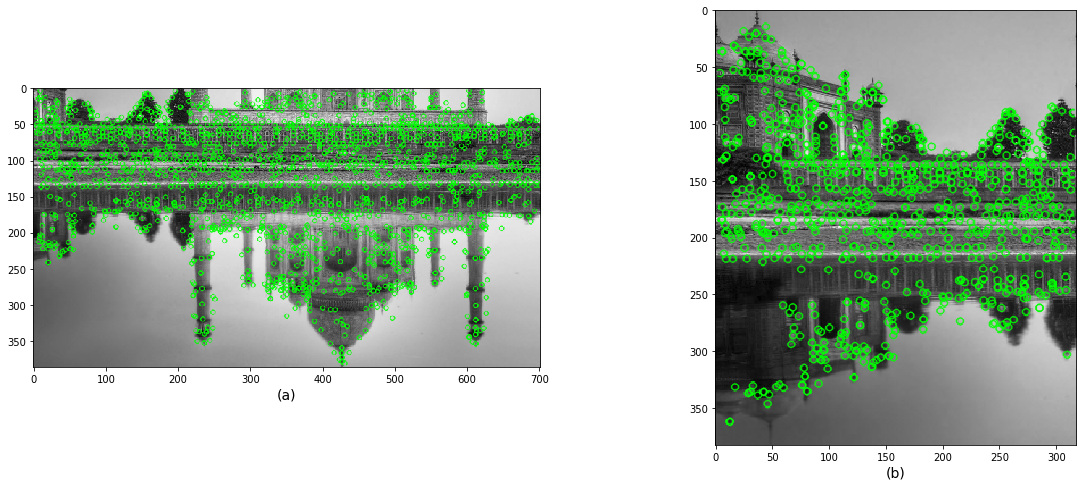

In [17]:
img6 = cv2.imread('eg2/img2_5.png', cv2.IMREAD_UNCHANGED)
img7 = cv2.imread('eg2/img2_4.png', cv2.IMREAD_UNCHANGED)
image1_gray=cv2.cvtColor(img6,cv2.COLOR_BGR2GRAY)
image2_gray=cv2.cvtColor(img7,cv2.COLOR_BGR2GRAY)

image1=cv2.cvtColor(img6,cv2.COLOR_BGR2RGB)
image2=cv2.cvtColor(img7,cv2.COLOR_BGR2RGB)
sift =cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(image1_gray,None)
kp2, des2 = sift.detectAndCompute(image2_gray,None)
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(image1_gray,kp1,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(image2_gray,kp2,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

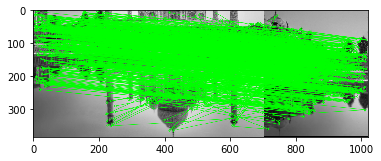

In [18]:
match = cv2.BFMatcher()
matches = match.knnMatch(des1,des2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.9*n.distance:
        good.append(m)

draw_params = dict(matchColor=(0,255,0),
                       singlePointColor=None,
                       flags=2)

img3 = cv2.drawMatches(image1_gray,kp1,image2_gray,kp2,good,None,**draw_params)
plt.imshow(img3)

In [19]:
MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    h,w = image2_gray.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M)
    #img2 = cv2.polylines(image2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

    #plt.imshow(img2)
else:
    print("Not enought matches are found - %d/%d", (len(good)/MIN_MATCH_COUNT))

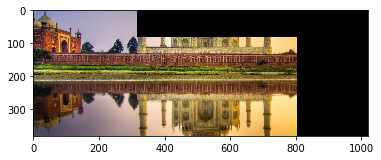

In [20]:
dst = cv2.warpPerspective(image1,M,(image2.shape[1] + image1.shape[1], image2.shape[0]))
dst[0:image2.shape[0],0:image2.shape[1]] = image2
plt.imshow(dst)


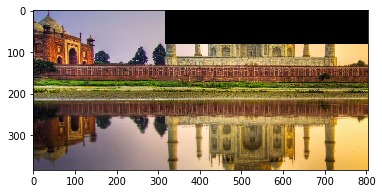

In [21]:
plt.imshow(trim(dst))
panorama_img = trim(dst)

Text(0.5, 0, '(b)')

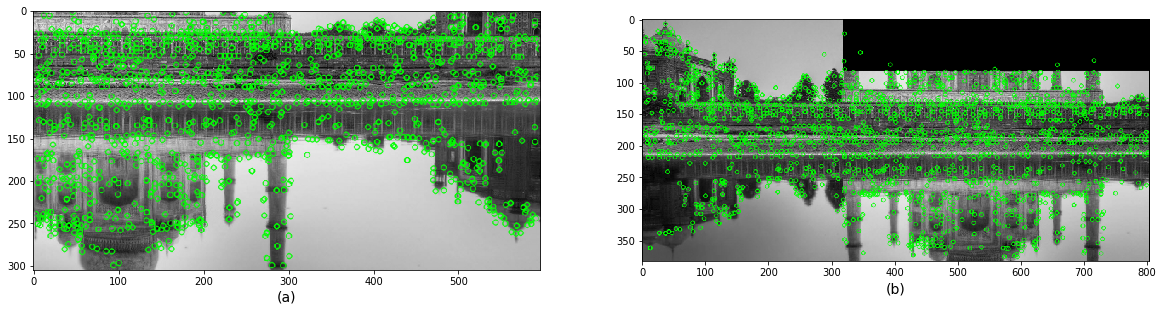

In [22]:
img8 = cv2.imread('eg2/img2_6.png', cv2.IMREAD_UNCHANGED)
img9 = panorama_img
image1_gray=cv2.cvtColor(img8,cv2.COLOR_BGR2GRAY)
image2_gray=cv2.cvtColor(img9,cv2.COLOR_BGR2GRAY)

image1=cv2.cvtColor(img8,cv2.COLOR_BGR2RGB)
# image2=cv2.cvtColor(img9,cv2.COLOR_BGR2RGB)
image2 = img9
sift =cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(image1_gray,None)
kp2, des2 = sift.detectAndCompute(image2_gray,None)
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(image1_gray,kp1,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(image2_gray,kp2,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

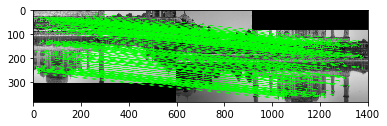

In [23]:
match = cv2.BFMatcher()
matches = match.knnMatch(des1,des2,k=2)

good = []
for m,n in matches:
    if m.distance < 0.2*n.distance:
        good.append(m)

draw_params = dict(matchColor=(0,255,0),
                       singlePointColor=None,
                       flags=2)

img3 = cv2.drawMatches(image1_gray,kp1,image2_gray,kp2,good,None,**draw_params)
plt.imshow(img3)

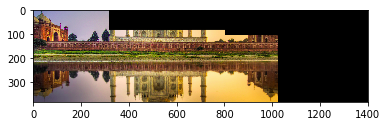

In [24]:
MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    h,w = image2_gray.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M)
    #img2 = cv2.polylines(image2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

    #plt.imshow(img2)
else:
    print("Not enought matches are found - %d/%d", (len(good)/MIN_MATCH_COUNT))
dst = cv2.warpPerspective(image1,M,(image2.shape[1] + image1.shape[1], image2.shape[0]))
plt.imshow(dst)
dst[0:image2.shape[0],0:image2.shape[1]] = image2
plt.imshow(dst)

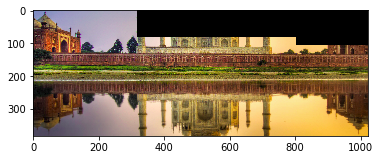

In [25]:
plt.imshow(trim(dst))

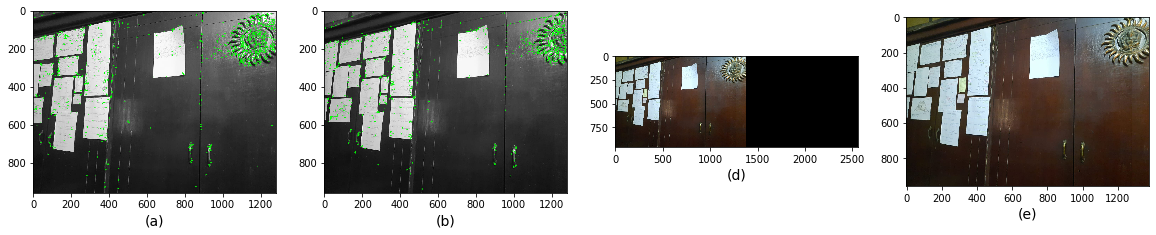

In [26]:
def panorama(img2, img1, factor):
    img12 = cv2.imread(img2, cv2.IMREAD_UNCHANGED)
    img13 = cv2.imread(img1, cv2.IMREAD_UNCHANGED)
    image1_gray=cv2.cvtColor(img12,cv2.COLOR_BGR2GRAY)
    image2_gray=cv2.cvtColor(img13,cv2.COLOR_BGR2GRAY)

    image1=cv2.cvtColor(img12,cv2.COLOR_BGR2RGB)
    image2=cv2.cvtColor(img13,cv2.COLOR_BGR2RGB)
    sift =cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(image1_gray,None)
    kp2, des2 = sift.detectAndCompute(image2_gray,None)
    fig, (ax1,ax2, ax4, ax5) = plt.subplots(nrows=1, ncols=4, figsize=(20,8), constrained_layout=False)
    ax1.imshow(cv2.drawKeypoints(image1_gray,kp1,None,color=(0,255,0)))
    ax1.set_xlabel("(a)", fontsize=14)
    ax2.imshow(cv2.drawKeypoints(image2_gray,kp2,None,color=(0,255,0)))
    ax2.set_xlabel("(b)", fontsize=14)
    
    match = cv2.BFMatcher()
    matches = match.knnMatch(des1,des2,k=2)

    good = []
    for m,n in matches:
        if m.distance < 0.2*n.distance:
            good.append(m)

    draw_params = dict(matchColor=(0,255,0),
                           singlePointColor=None,
                           flags=2)

    img3 = cv2.drawMatches(image1_gray,kp1,image2_gray,kp2,good,None,**draw_params)
    plt.imshow(img3)
    MIN_MATCH_COUNT = 10
    if len(good) > MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        h,w = image2_gray.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts, M)
        dst = cv2.warpPerspective(image1,M,(image2.shape[1] + image1.shape[1], image2.shape[0]))
        dst[0:image2.shape[0],0:image2.shape[1]] = image2
        ax4.imshow(dst)
        ax4.set_xlabel("(d)", fontsize=14)
        ax5.imshow(trim(dst))
        ax5.set_xlabel("(e)", fontsize=14)
    else:
        print("Not enought matches are found - %d/%d", (len(good)/MIN_MATCH_COUNT))
panorama('ex1/img2.jpeg', 'ex1/img1.jpeg', 0.3)

Not enought matches are found - %d/%d 0.0


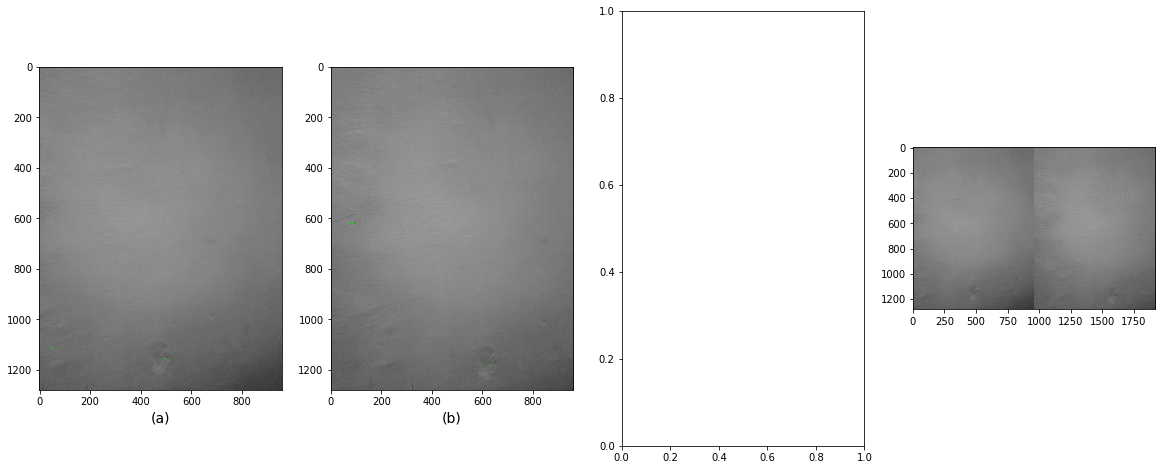

In [27]:
panorama('ex2/img2.jpeg', 'ex2/img1.jpeg', 1.2)

The panorama function doesn't seem to work properly because though there are not enough features that exist, to match in the first place

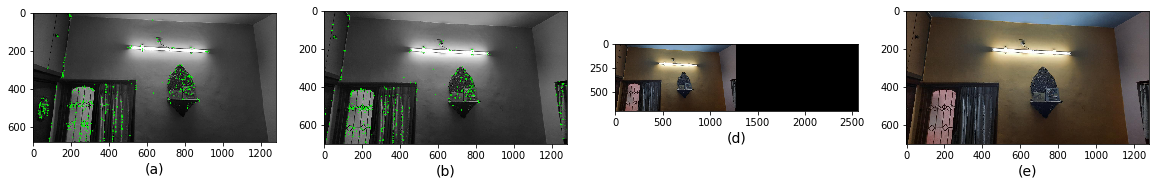

In [28]:
panorama('ex3/img2.jpeg', 'ex3/img1.jpeg', 0.7)

The panorama function works as expected to.

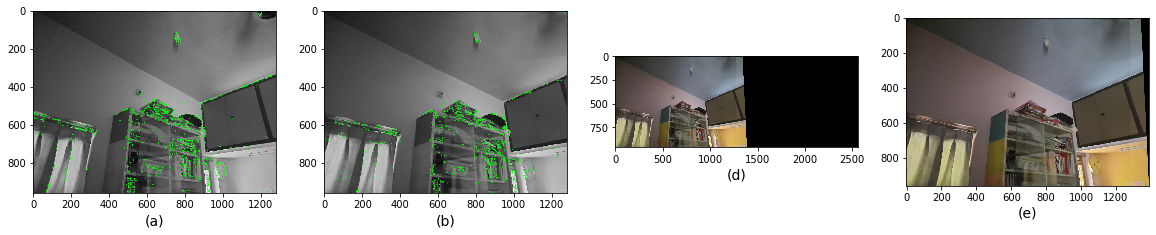

In [29]:
panorama('ex4/img2.jpeg', 'ex4/img1.jpeg', 0.7)

### Task 1

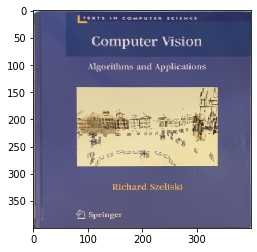

In [30]:
img13 = cv2.imread('book1.jpg', cv2.IMREAD_UNCHANGED)
img13 = cv2.cvtColor(img13, cv2.COLOR_BGR2RGB)
height, width = 400, 400
im_dst=np.zeros((height, width, 3))
pts_src = np.array([[318, 256],[534, 372],[316, 670],[73, 473]], dtype=float)
dst_pts = np.array([[0, 0], [399, 0], [399, 399],[0, 399]], dtype=float)
M, mask = cv2.findHomography(pts_src, dst_pts, cv2.RANSAC, 5.0)
im_dst=cv2.warpPerspective(img13, M, (im_dst.shape[1], im_dst.shape[0]))
plt.imshow(im_dst)

### Task 2

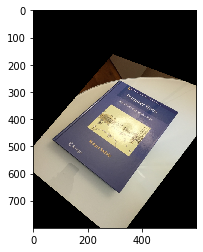

In [31]:
img_dst = cv2.imread('book1.jpg', cv2.IMREAD_UNCHANGED)
img_src = cv2.imread('book2.jpg', cv2.IMREAD_UNCHANGED)
img_dst = cv2.cvtColor(img_dst, cv2.COLOR_BGR2RGB)
img_src = cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB)
pts_src = np.array([[141, 131], [480, 159], [493, 630],[64, 601]], dtype=float)
pts_dst = np.array([[318, 256],[534, 372],[316, 670],[73, 473]], dtype=float)
M, mask = cv2.findHomography(pts_src, pts_dst, cv2.RANSAC, 5.0)
im_out=cv2.warpPerspective(img_src, M, (img_dst.shape[1], img_dst.shape[0]))
plt.imshow(im_out)


### Task 3

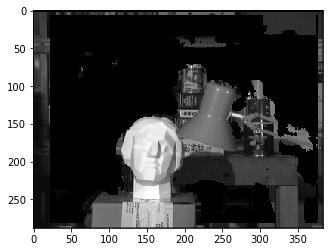

In [32]:
iml = cv2.imread('tsukuba_l.png', cv2.IMREAD_GRAYSCALE)
imr = cv2.imread('tsukuba_r.png', cv2.IMREAD_GRAYSCALE)
stereo=cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity_map = stereo.compute(iml, imr).astype(np.uint32)
for i in range(iml.shape[0]):
    for j in range(iml.shape[1]):
        if disparity_map[i, j] <120:
            iml[i, j]=0
plt.imshow(iml, cmap = "gray")


### Task 4

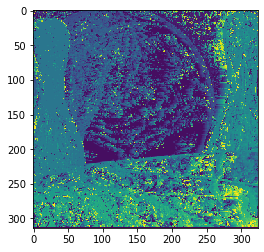

In [34]:
I1=cv2.imread("view0.png",cv2.IMREAD_GRAYSCALE)
I2=cv2.imread("view1.png",cv2.IMREAD_GRAYSCALE)

ssd = []
ht,wdt=I1.shape
disparity=np.zeros([I2.shape[0],I2.shape[1]])
for item in range(I1.shape[0]):
    temp=[]
    for lol in range(I1.shape[1]):
        temp.append([0,0])
    ssd.append(temp)
threshold=30
for i in range(40,len(I1)-1):
    for j in range(threshold,len(I1[0])-1):
        temp2=10000000000000
        for k in range(1,threshold-1):
            temp1=np.sum(np.square(I1[i-1:i+1,j-1:j+1]-I2[i-1:i+1,j-k:j-k+2])) 
            if(temp1<temp2):
                ssd[i][j]=k
                temp2=temp1
        disparity[i][j]=abs(ssd[i][j])*(255/threshold)

plt.imshow(np.hstack([disparity[40:wdt,30:ht]]))